In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as la
import pickle
import os.path

import qiskit
from qiskit import Aer
from qiskit import IBMQ
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.circuit import Parameter
from qiskit.providers.aer import noise
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import datetime
import networkx as nx
import itertools
import glob

# some definitions of gate unitaries
s0 = np.array([[1,0],[0,1]])
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
s = np.array([sx, sy, sz])
h = np.array([[1,1],[1,-1]])/np.sqrt(2)

# number of qubits in the quantum circuit
n_qubits = 5
state = ['|0>','|1>','|+>','|->','|y+>','|y->']

In [2]:
IBMQ.load_account()

#provider = IBMQ.get_provider(group='open')
provider = IBMQ.get_provider(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantum-dynamics')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q-sherbrooke', group='iq-staff', project='quantu

In [3]:
files = glob.glob('exp-data/*.pickle')
data = []
for f in files:
    try:
        infile = open(f,'rb')
        datasets = []
        for i in np.arange(len(state)):
            datasets.append(pickle.load(infile))
        infile.close()
    except:
        infile.close()
    else:
        data.append(datasets)

In [4]:
nqs = []
qvs = []
for i in range(len(data)):
    datasets = data[i]
    qc = datasets[0]['qc']
    backend = provider.get_backend(qc)
    config = backend.configuration()
    qv = config.quantum_volume
    n_qubits = config.n_qubits
    nqs.append(n_qubits)
    qvs.append(qv)

In [5]:
idx = np.flip(np.argsort(qvs))
qvs = [qvs[i] for i in idx]
nqs = [nqs[i] for i in idx]
data = [data[i] for i in idx]

idx = np.flip(np.argsort(nqs))
qvs = [qvs[i] for i in idx]
nqs = [nqs[i] for i in idx]
data = [data[i] for i in idx]

In [6]:
nqs

[65, 27, 27, 20, 15, 7, 5, 5, 5, 5, 5]

C:\Users\rafae\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
C:\Users\rafae\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


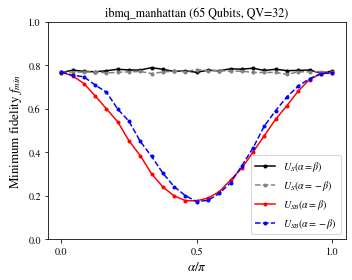

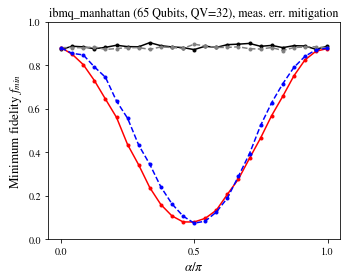

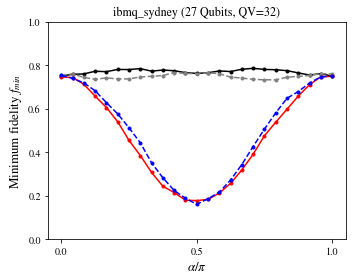

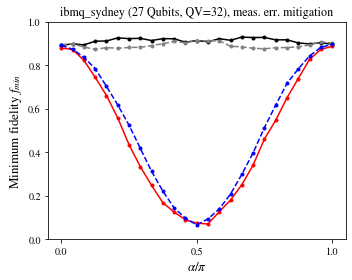

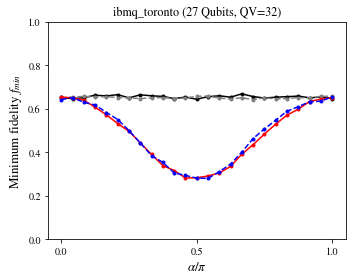

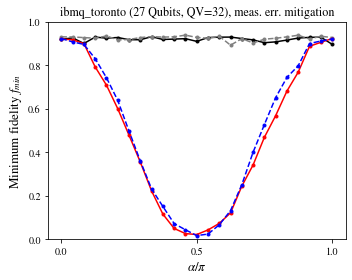

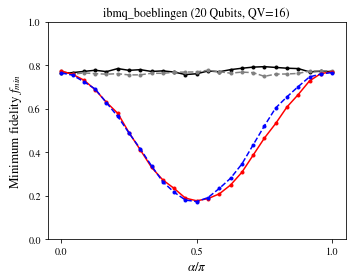

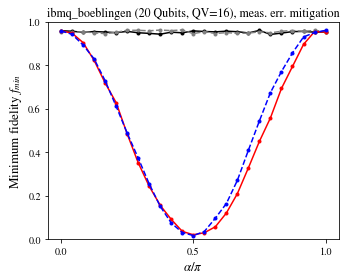

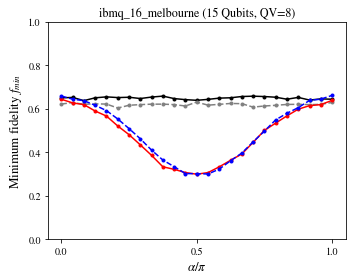

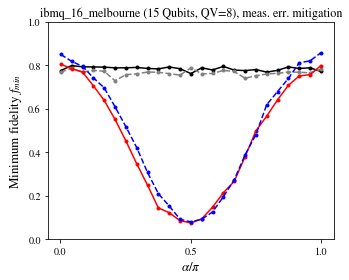

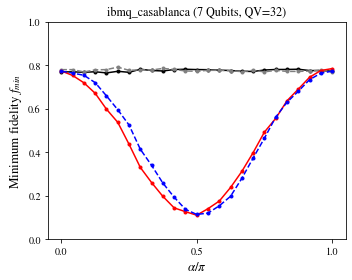

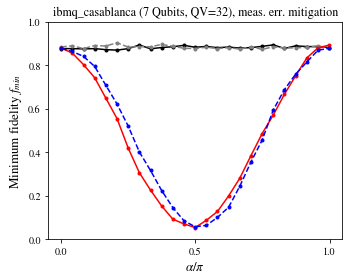

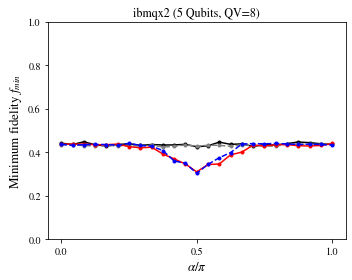

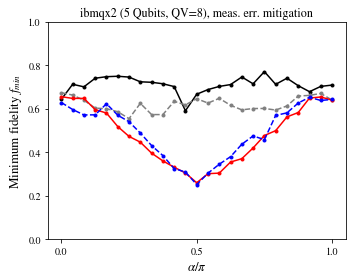

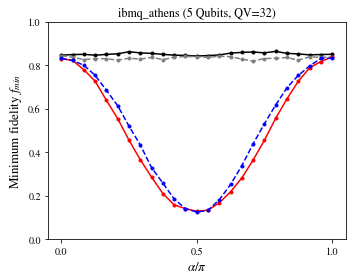

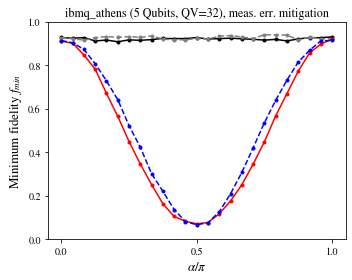

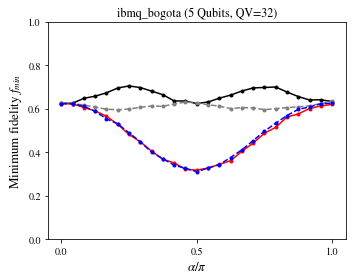

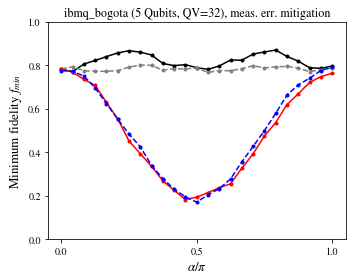

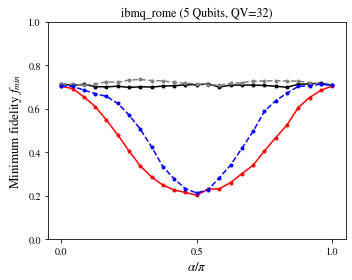

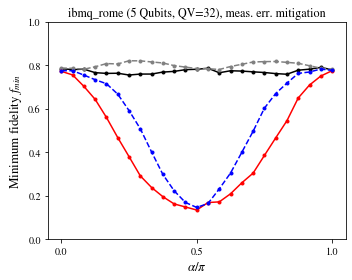

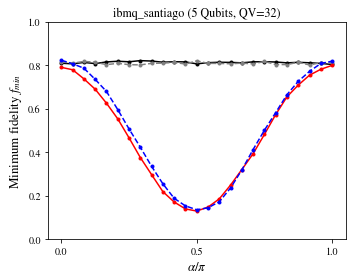

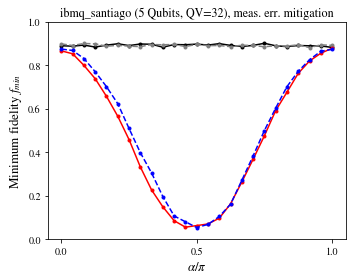

In [7]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

for i in range(len(data)):
    for mit in [1,0]:
        datasets = data[i]
        plt.rcParams["figure.figsize"] = (5, 4)
        fff = datasets[0]["fidelity"][mit].real
        for initial_s in np.arange(1,6):
            for jj in np.arange(4):
                fff[jj] = np.minimum(fff[jj], datasets[initial_s]["fidelity"][mit,jj].real)
        fig, ax = plt.subplots()
        style = ['.-','.-','.--','.--']
        colors = ['black', 'red', 'gray', 'blue']
        legend = [r'$U_S(\alpha=\beta)$',r'$U_{SB}(\alpha=\beta)$',r'$U_S(\alpha=-\beta)$',r'$U_{SB}(\alpha=-\beta)$']
        order = [0,2,1,3]
        for kk in order:
            ax.plot(datasets[0]["alphas"]/np.pi/2,fff[kk],style[kk],label=legend[kk], color=colors[kk])
        plt.ylim((0,1))
        #plt.xlim((-0.15,1.15))
        if mit==1 and i==0:
            plt.legend()
        ax.set_xticks([0, 0.5, 1])


        FONTSIZE = 13
        plt.xlabel(r"$\alpha/\pi$",fontsize=FONTSIZE)
        plt.ylabel(r"Minimum fidelity $f_{min}$",fontsize=FONTSIZE)
        qc = datasets[0]['qc']
        backend = provider.get_backend(qc)
        config = backend.configuration()
        qv = config.quantum_volume
        n_qubits = config.n_qubits
        mmstring = ''
        if mit == 0:
            mmstring = ', meas. err. mitigation'
        plt.title(f'{qc} ({n_qubits} Qubits, QV={qv}){mmstring}')
        plt.tight_layout()
        plt.savefig(f'results/fmin_qc{i}_mit{mit}.pdf')

In [8]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
state = ['0','1','+','-',r'\circlearrowright',r'\circlearrowleft']

#plt.rc('text.latex', preamble=r'\usepackage{braket}')
params = {'text.latex.preamble' : [r'\usepackage{braket}', r'\usepackage{amsmath}']}
matplotlib.rcParams.update(params)
#matplotlib.verbose.level = 'debug-annoying'

for i in range(len(data)):
    for mit in [1,0]:
        datasets = data[i]
        plt.rcParams["figure.figsize"] = (4.5, 3)
        fff = datasets[0]["fidelity"][mit].real
        for initial_s in np.arange(6):
            for jj in np.arange(4):
                fff[jj] = datasets[initial_s]["fidelity"][mit,jj].real
            fig, ax = plt.subplots()
            style = ['.-','.-','.--','.--']
            colors = ['black', 'red', 'gray', 'blue']
            legend = [r'$U_S(\alpha=\beta)$',r'$U_{SB}(\alpha=\beta)$',r'$U_S(\alpha=-\beta)$',r'$U_{SB}(\alpha=-\beta)$']
            order = [0,2,1,3]
            for kk in order:
                ax.plot(datasets[0]["alphas"]/np.pi/2,fff[kk],style[kk],label=legend[kk], color=colors[kk])
            plt.ylim((0,1))
            #plt.legend()
            ax.set_xticks([0, 0.5, 1])


            FONTSIZE = 13
            plt.xlabel(r"$\alpha/\pi$",fontsize=FONTSIZE)
            plt.ylabel("Fidelity",fontsize=FONTSIZE)
            plt.text(0.02,0.1,r'$\left\|\psi_{in}\right> = |'+state[initial_s]+r'\rangle$',fontsize=15)

            qc = datasets[0]['qc']
            backend = provider.get_backend(qc)
            config = backend.configuration()
            qv = config.quantum_volume
            n_qubits = config.n_qubits
            mmstring = ''
            if mit == 0:
                mmstring = ', meas. err. mitigation'
            if initial_s == 0:
                plt.title(f'{qc} ({n_qubits} Qubits, QV={qv}){mmstring}')

            plt.tight_layout()
            plt.savefig(f'results/fidelity_qc{i}_mit{mit}_state{initial_s}.pdf')
            plt.close()